## 1. Data Collection and Cleaning

In [203]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as ex
import seaborn as sns
from sklearn.preprocessing import StandardScaler

sns.set(style= 'whitegrid', color_codes=True)
sns.set_theme(context='notebook',style='darkgrid',
              palette='deep',font='sans-serif',font_scale=1,color_codes=True,rc=None)
%matplotlib inline #These lines are only for visual plots

df1 = pd.read_csv('inputs/male_players.csv')
df2 = pd.read_csv('inputs/female_players.csv') #We open the inputs datasets

df1['gender'] = 'M'
df2['gender'] = 'F' #We add a new label to these dataset, to differentiate men and women players

df = pd.concat([df1, df2]) #Now, we can concatenate the two datasets

df.drop(df.filter(regex="Unname"),axis=1, inplace=True) #We have to remove the additional "index" columns from the original dataset

df.to_csv('outputs/full_players.csv', index = False) #We save the final dataset on which we will work on as a csv file.

UsageError: unrecognized arguments: #These lines are only for visual plots


In [ ]:
df = pd.read_csv('outputs/full_players.csv')
df.head()

In [ ]:
print('Shape:', df.shape,'\n')
print(df.columns)

In [ ]:
#From these methodes, we can notice that we will work on a dataset of 20189 players from FIFA 2024, based on 110 columns.
df.info()

In [ ]:
df.isna().sum()

There are no "abnormal" missing values, since players without contracts or clubs are not "free players" who have not yet found a club.
Players without transfer clauses are due to the fact that this function is forbidden in several countries.

## 1.1. Basic Data Summary

In [ ]:
df.describe()

## 1.2. Basic Visualisation

We will dive into the dataset to better understand some key points in Football, such as the peak for players in terms of age, positions, nationality...

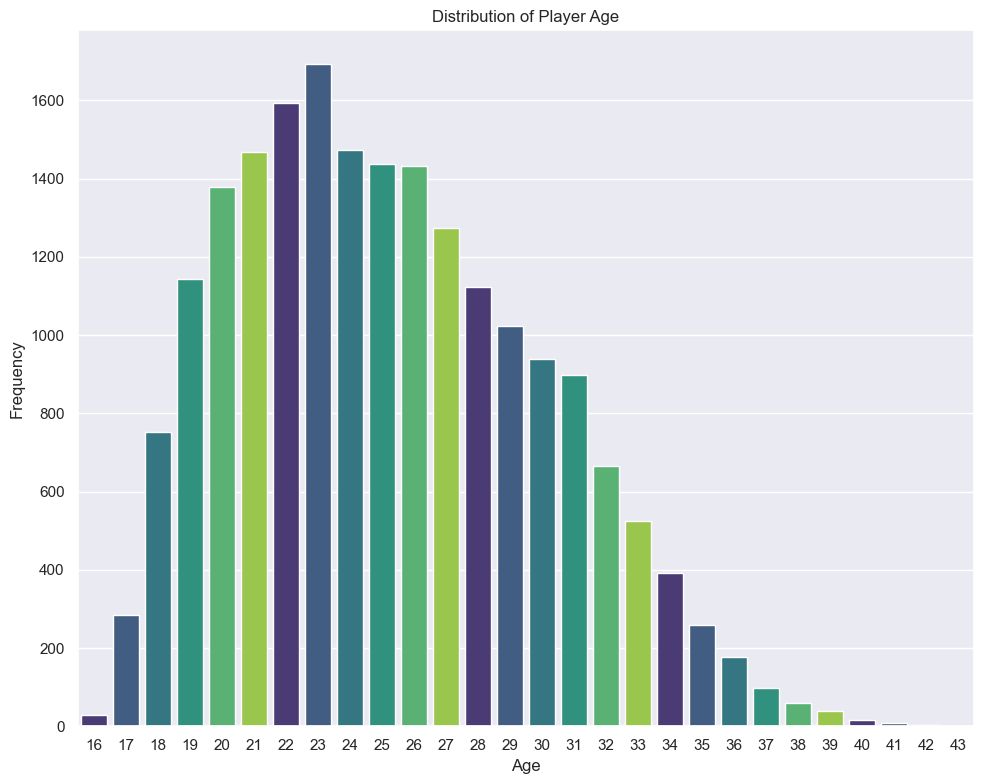

In [204]:
age_counts = df.groupby('age')['long_name'].count()
plt.figure(figsize=(10, 8))
sns.barplot(x = age_counts.index, y = age_counts.values,palette=sns.color_palette('viridis'), hue=age_counts.index, legend=False )
plt.title('Distribution of Player Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

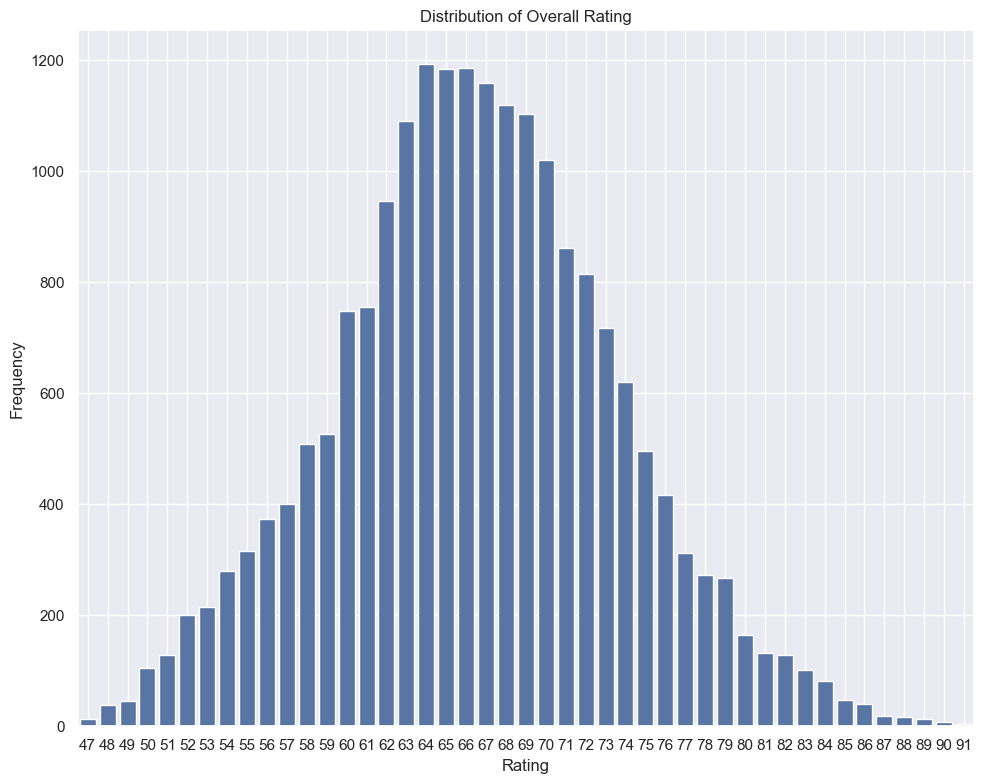

In [205]:
rating_counts = df.groupby('overall')['long_name'].count()
plt.figure(figsize=(10, 8))
sns.barplot(x = rating_counts.index, y = rating_counts.values, )
plt.title('Distribution of Overall Rating')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

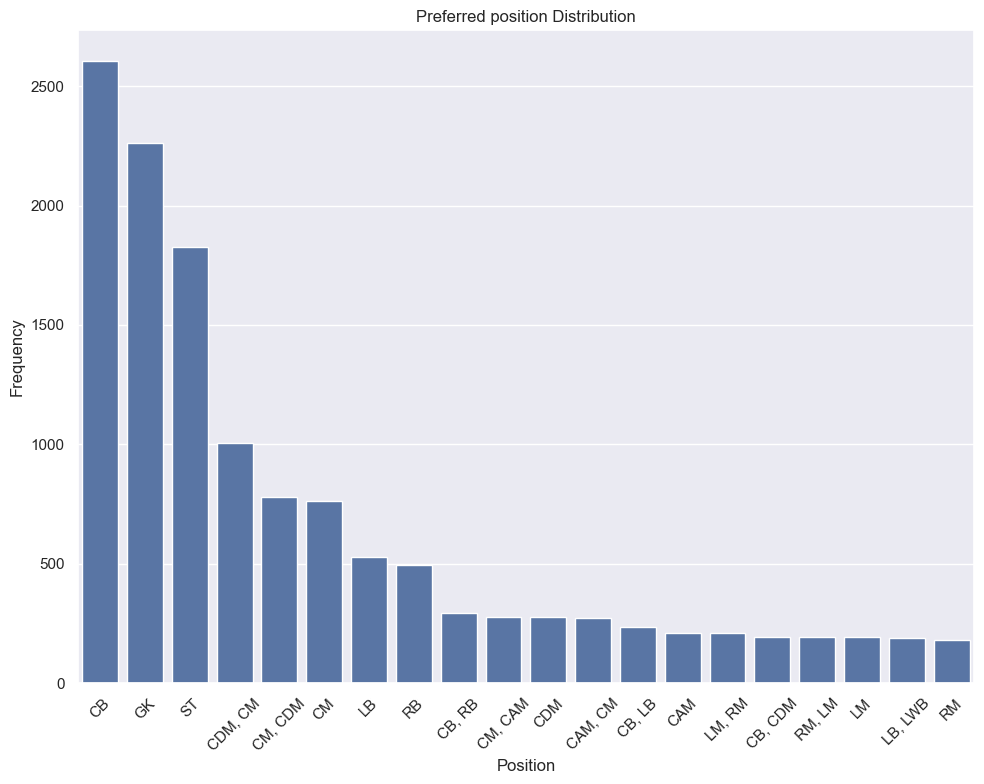

In [206]:
position_counts = df['player_positions'].value_counts(ascending=False).head(20)
plt.figure(figsize=(10, 8))
sns.barplot(x = position_counts.index, y = position_counts.values)
plt.title('Preferred position Distribution')
plt.xlabel('Position')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

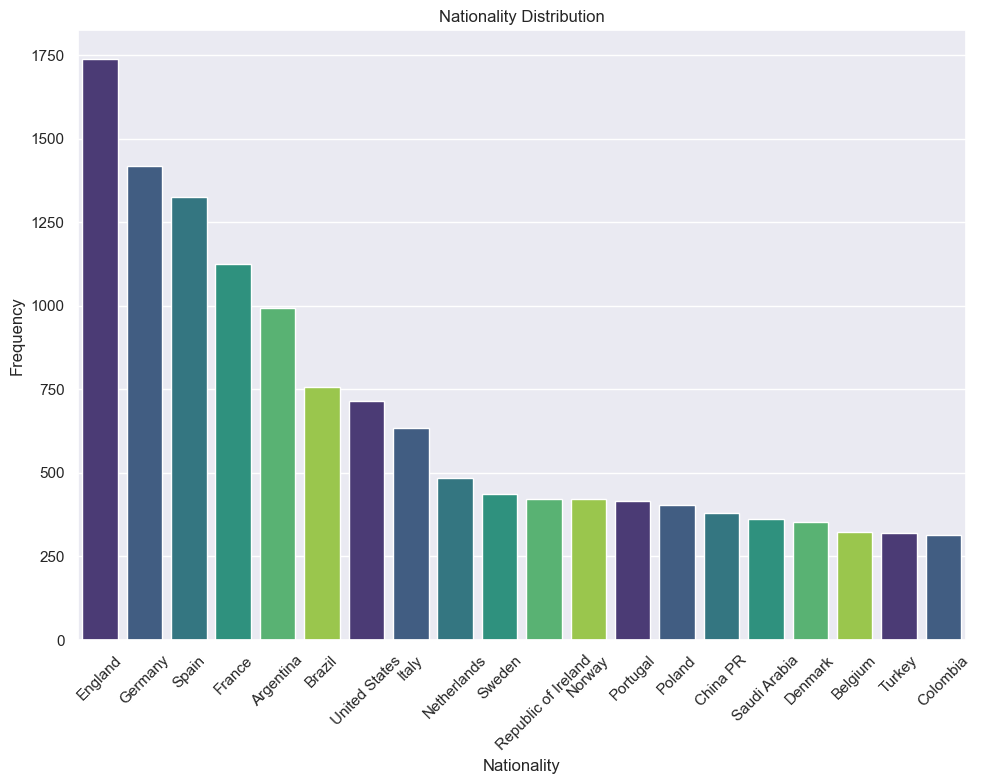

In [207]:
nationality_counts = df['nationality_name'].value_counts(ascending=False).head(20)
plt.figure(figsize=(10, 8))
sns.barplot(x = nationality_counts.index, y = nationality_counts.values,palette=sns.color_palette('viridis'), hue=nationality_counts.index, legend=False)
plt.title('Nationality Distribution')
plt.xlabel('Nationality')
plt.xticks(rotation = 45)
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

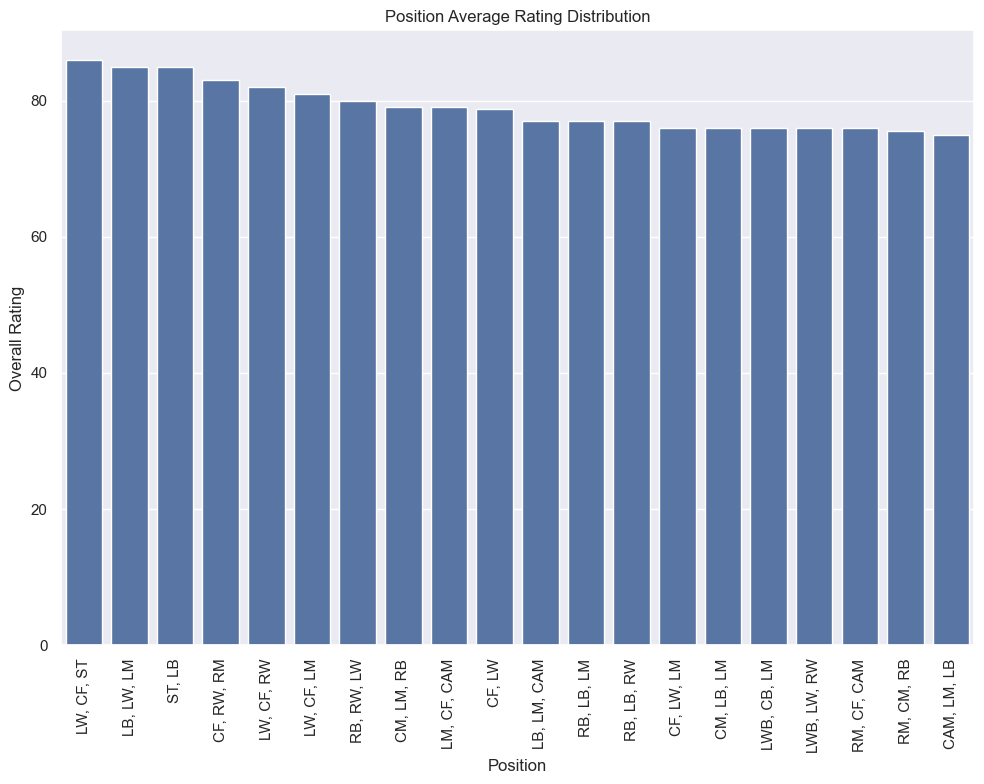

In [208]:
position_rating = df.groupby('player_positions')['overall'].mean().nlargest(20)
plt.figure(figsize=(10, 8))
sns.barplot(x = position_rating.index, y = position_rating.values)
plt.title('Position Average Rating Distribution')
plt.xlabel('Position')
plt.xticks(rotation = 90)
plt.ylabel('Overall Rating')
plt.tight_layout()
plt.show()

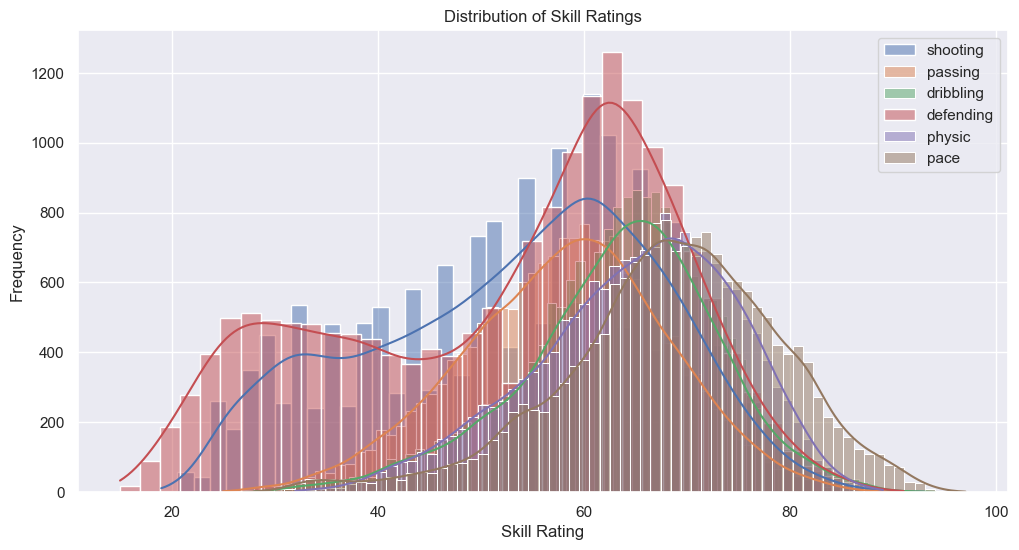

In [209]:
skill_columns = ['shooting', 'passing', 'dribbling', 'defending', 'physic', 'pace']
plt.figure(figsize=(12, 6))

for skill in skill_columns:
    sns.histplot(df[skill], kde=True, label=skill)

plt.title('Distribution of Skill Ratings')
plt.xlabel('Skill Rating')
plt.ylabel('Frequency')
plt.legend()
plt.show()

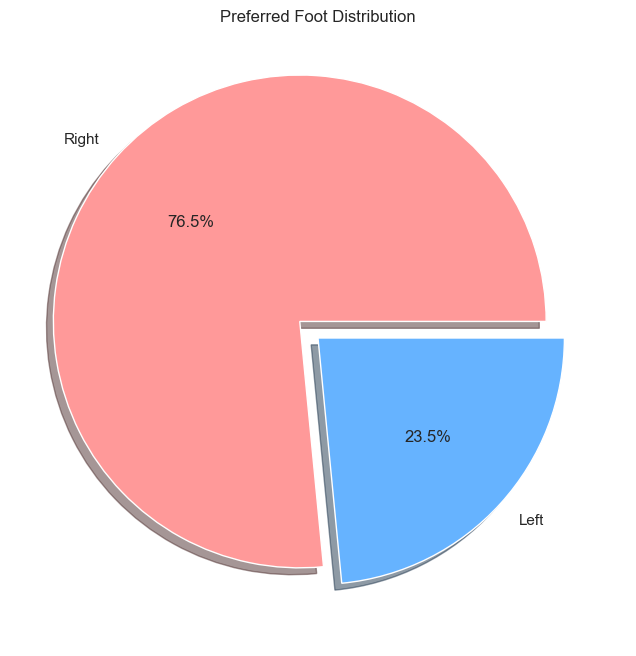

In [210]:
foot_count = df['preferred_foot'].value_counts()

colors = ['#ff9999', '#66b3ff']

explode = (0.1, 0)

plt.figure(figsize=(8, 8))
plt.pie(foot_count, labels=foot_count.index, autopct='%1.1f%%', colors=colors, explode=explode, shadow=True)
plt.title('Preferred Foot Distribution')
plt.show()

While the percentage of lefties in the world population ranges from 10 to 13%, they are more represented in some sports. We can see that this is the case in football.

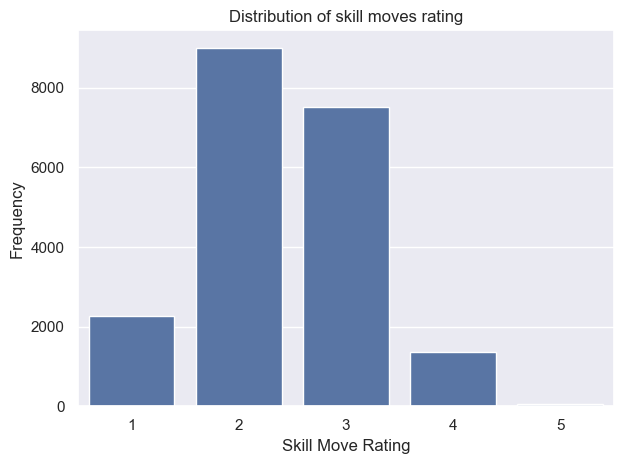

In [211]:
skill_counts = df['skill_moves'].value_counts()
sns.barplot(x = skill_counts.index, y = skill_counts.values)
plt.title('Distribution of skill moves rating')
plt.ylabel('Frequency')
plt.xlabel('Skill Move Rating')
plt.tight_layout()
plt.show()

## 2. Questions

### 2.1. Question 1 : Which clubs have the best Economy* ?

Interpretation of Economy : How much quality player overall a Club can get for every Euro spent.

In [212]:
clubData = {'Club': df.club_name, 'League': df.league_name, 'Overall' : df.overall,
            'Wage': df.wage_eur} #We isolate the informations we will need for this study.

clubDataDf = pd.DataFrame(clubData, columns = ['Club', 'League', 'Overall', 'Wage']) #We can create a new dataset only with the informations we had chosen before.

In [213]:
dct = dict(df.club_name.value_counts())
find_value_lambda = lambda x: dct[x] #Creation of lambda function

In [214]:
clubDataDf.dropna(inplace = True)
overallList = []
p = 0

''' Dividing the Overall of each row by the Club count so
 that when we do groupby, we get the appropriate mean
 Overall value for the club ( kind a normalization )'''

for i in clubDataDf.values:
    overallList.append( i[2] / find_value_lambda( i[0] ) )

x = np.reshape(overallList, (len(overallList), 1))
new_club_data = clubDataDf.drop(columns = ['Overall'], inplace = False)
new_club_data['Overall'] = x

new_club_df = new_club_data.groupby(by = 'Club',
                                      as_index=False).agg({'League': 'first', 'Wage': 'sum', 'Overall': 'sum'})
#This new dataframe is the aggregation of each club's wages and overalls.

new_club_df['Economy'] = new_club_df['Overall'] / new_club_df['Wage']

In [215]:
top_10_clubs = new_club_df.sort_values(by=['Economy'], ascending=False).head(10)

In [216]:
ex.bar(x = top_10_clubs.Club, y = top_10_clubs.Economy,
       width = 650, height = 500, labels = {'y':'Economy', 'x':'Clubs'}, color = top_10_clubs.Economy)

Deportivo Binacional is the club which has the best Economy.

In [217]:
league_avg_economy = new_club_df.groupby('League')['Economy'].mean().sort_values(ascending=False)

fig = ex.bar(league_avg_economy, title='Average Team Economy by League', template='plotly_white')
fig.show()

The league with the best mean Economy is Liga de Futbol Prof (Bolivia) !

### Treemap of Teams by League

This treemap provides a hierarchical view of teams grouped by their leagues. The size of each team's box is proportional to its overall economy.

In [218]:
fig = ex.treemap(new_club_df, path=['League', 'Club'], values='Economy',
                 title='Treemap of Teams by League based on Economy')
fig.show() #You can click on every league to look its clubs' economy !

The results of this study can be explained quite simply.
It seems quite logical that the best ratios are found in so-called "secondary" leagues because the salaries that the players of the best world teams receive are not justified only by their sporting level but by other external factors such as communication, social networks, the sale of swimwear and merch, to dissuade competitors...
Between the best player of a Bolivian team and the best player of Real Madrid, we can find a salary gap of more than x1000. However, the Real Madrid player is not 1000x best in Football.

### 2.2. Question 2 :
- What is the relationship between age and individual potential of the player?
- How does age influence the players' value?

In [219]:
data = {'Age': df.age, 'Potential' : df.potential}

perf_df = pd.DataFrame(data, columns = ['Age', 'Potential']) #Same processus, we isolate the columns which will be useful and we create a new dataset only with these informations.
ex.box(x = 'Age', y = 'Potential', data_frame = perf_df, color = 'Age', boxmode = 'overlay', notched =True)

<Axes: xlabel='Age', ylabel='Potential'>

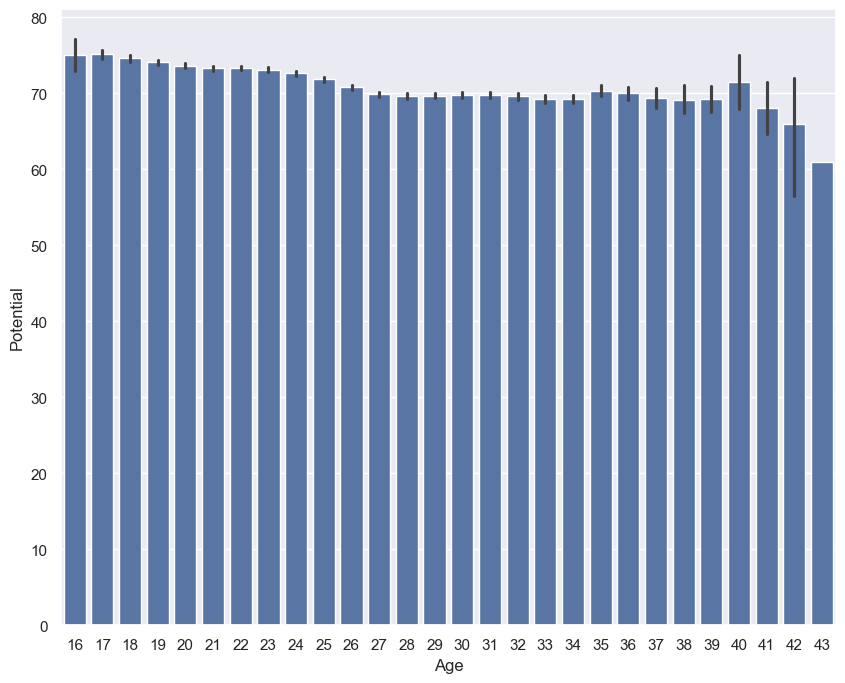

In [220]:
plt.figure(figsize=(10,8))
sns.barplot(x = 'Age', y = 'Potential', data = perf_df)

In [221]:
scaler = StandardScaler()

perf_df_standardised = scaler.fit_transform(perf_df[['Age','Potential']])
perf_df_standardised = pd.DataFrame(perf_df_standardised, columns = ['Age', 'Potential'])
perf_df_standardised.corr()

Age  Potential
Age        1.000000  -0.258079
Potential -0.258079   1.000000

<Axes: >

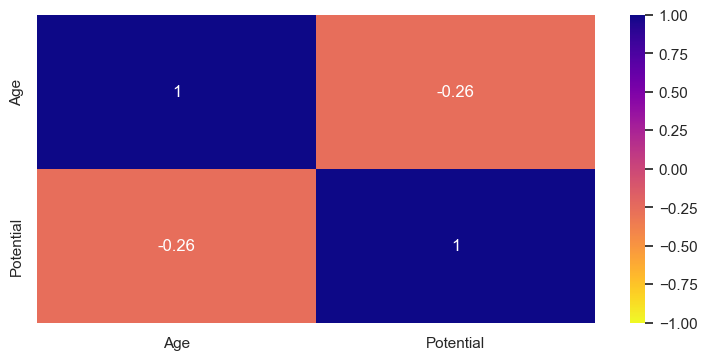

In [222]:
plt.figure(figsize = (9,4))
sns.heatmap(perf_df.corr(), vmin = -1, cmap = 'plasma_r', annot = True)

From Above Plots:
- We can observe that the Age is inversely proportional to the Potential of the player.
- A player shows average peak potential at the age of 17. After that it decreases until 28 and remain almost the same until the age of 40.
- There are also a lot of outliers which indicates that despite being of higher ager, some players show higher potential which is an exception for some cases.

In [223]:
perf_df['Value'] = df['value_eur']

ex.scatter(x = 'Age', y = 'Value', data_frame = perf_df,
           color = 'Age', opacity = 0.5, marginal_x = 'box')

There is a steep increase in the Value of a Player until the age of 24-25 years and after that it gradually starts decreasing. It hits the lowest at the age of 43 and the Value hits the highest at 24.

### 2.3. Question 3:
- Which attributes are helpful in deciding a player's potential?
- How do the traits contribute to the players' potential?

In [224]:
skill_df = df[["attacking_crossing","attacking_finishing","attacking_heading_accuracy","attacking_short_passing","attacking_volleys","skill_ball_control","skill_curve","skill_dribbling",
                         "skill_fk_accuracy","skill_long_passing","movement_acceleration","movement_agility","movement_balance","movement_reactions","movement_sprint_speed","power_jumping",
                         "power_long_shots","power_shot_power","power_stamina","power_strength","mentality_aggression","mentality_composure","mentality_interceptions","mentality_penalties",
                         "mentality_positioning","mentality_vision","defending_marking_awareness","defending_sliding_tackle","defending_standing_tackle","goalkeeping_diving","goalkeeping_handling","goalkeeping_kicking",
                         "goalkeeping_positioning","goalkeeping_reflexes", "potential"]]

# replacing the null values with the minimum of the column values
for index in skill_df.columns :
    skill_df[index].fillna(value = skill_df[index].min(), inplace = True)

/var/folders/r8/zqmq4mj91p1f_0yg_2vxkx_80000gn/T/ipykernel_15571/3208709663.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Axes: >

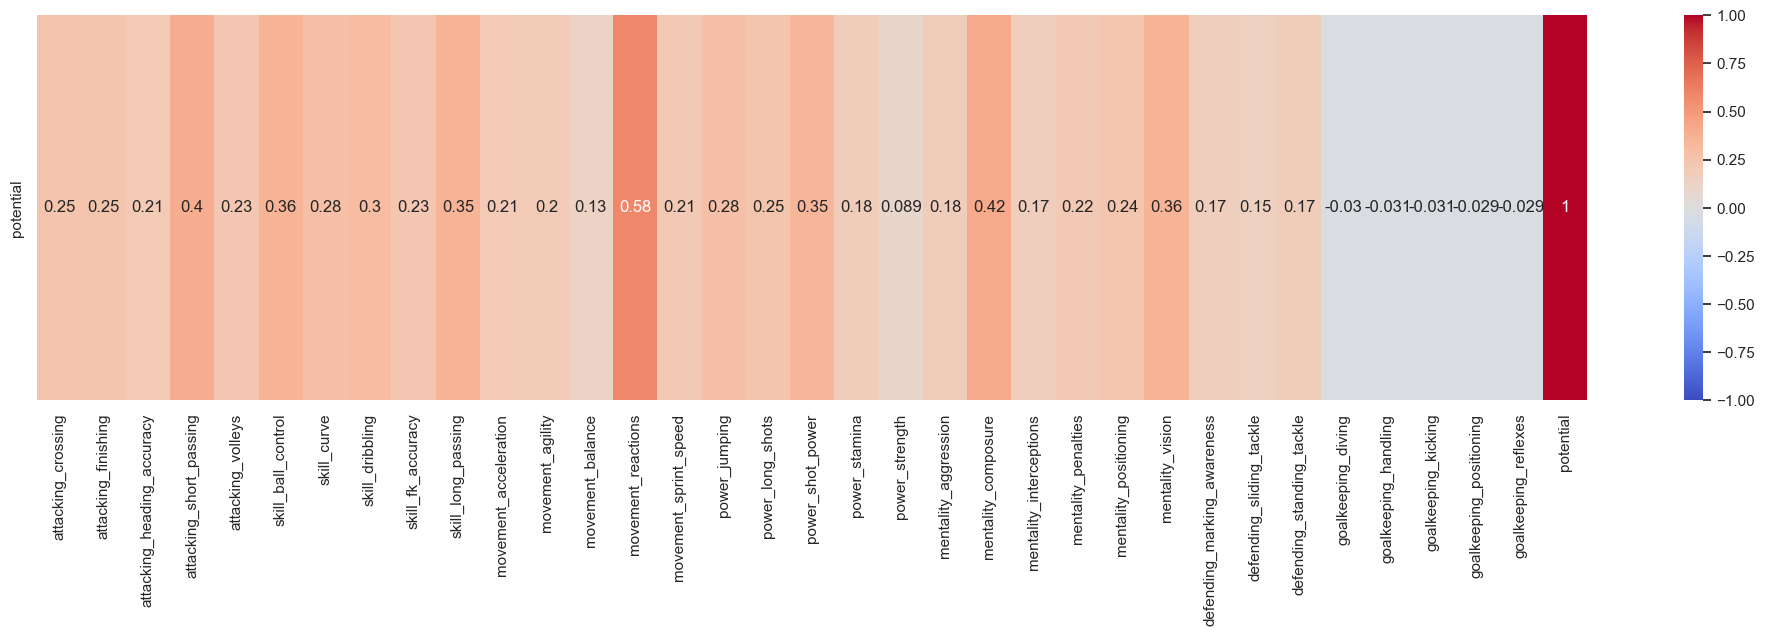

In [225]:
plt.figure(figsize=(25,5))
a = skill_df.corr().loc['potential':]
sns.heatmap(a, vmin=-1, cmap='coolwarm', annot = True)

From the Heatmap, we can observe that Reactions, Composure, Vision, ShortPassing, LongPassing  and ShotPower are the columns which have comparatively greater impact on the Potential of a player

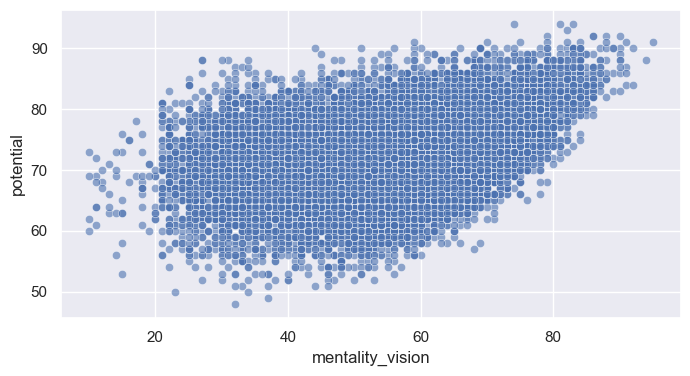

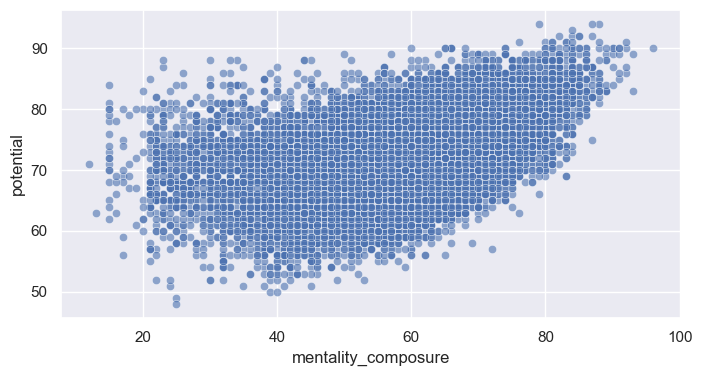

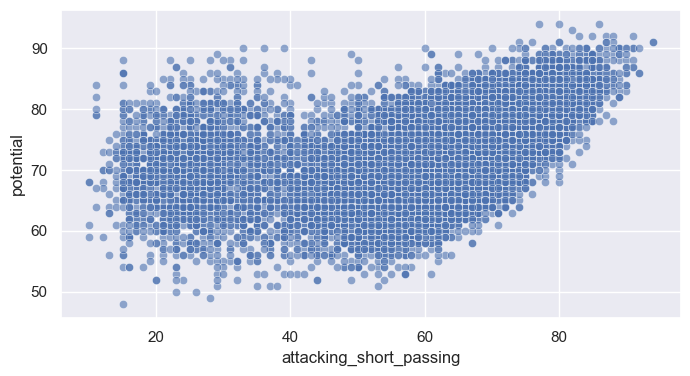

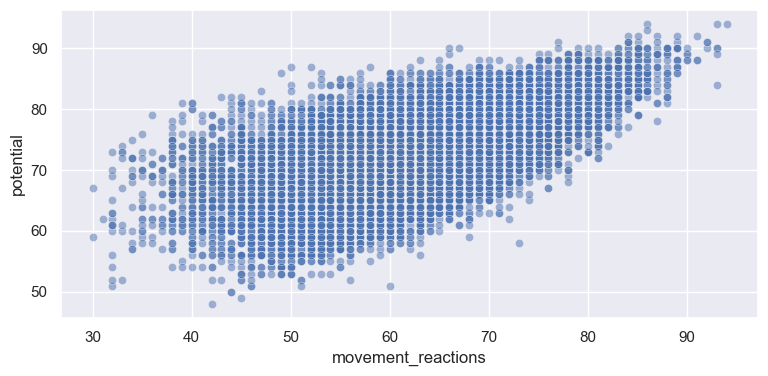

In [226]:
plt.figure(figsize=(8,4))
sns.scatterplot(x = 'mentality_vision', y = 'potential', data = skill_df, alpha=0.6)
plt.show()
plt.figure(figsize=(8,4))
sns.scatterplot(x = 'mentality_composure', y = 'potential', data = skill_df, alpha=0.6)
plt.show()
plt.figure(figsize=(8,4))
sns.scatterplot(x = 'attacking_short_passing', y = 'potential', data = skill_df, alpha=0.6)
plt.show()
plt.figure(figsize=(9,4))
sns.scatterplot(x = 'movement_reactions', y = 'potential', data = skill_df, alpha=0.5)
plt.show()

From these graphs, we can observe that as we had before, these attributes are correlated with the potential of a player.

### 2.4. Question 4 :
- Which features directly contribute to the wages of the players?

In [227]:
wage_data = {'Potential' : df['potential'], 'Overall' : df['overall'], 'Value' : df['value_eur'],
             'Height' : df['height_cm'], 'Weight' : df['weight_kg'], 'International Reputation' : df['international_reputation'],
             'Wage' : df['wage_eur']}
wage_df = pd.DataFrame(wage_data)

<Axes: >

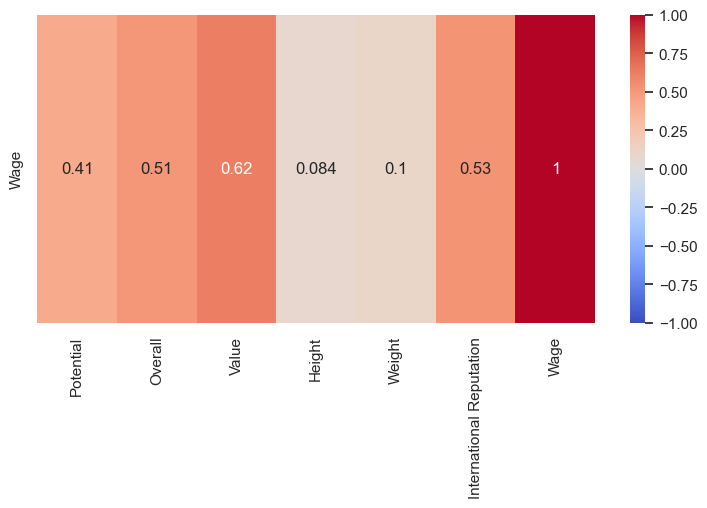

In [228]:
wage_corr_matrix = wage_df.corr().loc['Wage':]
plt.figure(figsize=(9,4))
sns.heatmap(wage_corr_matrix, vmin=-1, cmap='coolwarm', annot = True)

<Axes: xlabel='Value', ylabel='Wage'>

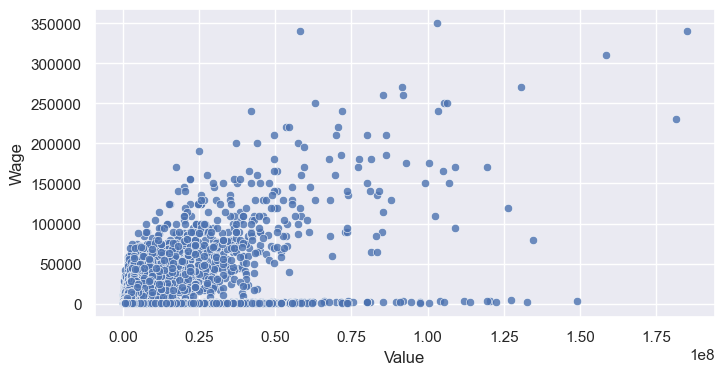

In [229]:
plt.figure(figsize=(8,4))
sns.scatterplot(x = 'Value', y ='Wage', data = wage_df, alpha=0.8)

So the Wage of a player is almost proportional to the Value of a player. If the value of the player increases, the wage of the player also increases.
From the heatmap, we can observe that the wage is mostly determined by the value, the international reputation and the overall, which means that the wage is more determined by the current level of the player than his potential, and that the height and the weight of the player are not factors for the wage.

<Axes: xlabel='International Reputation', ylabel='Wage'>

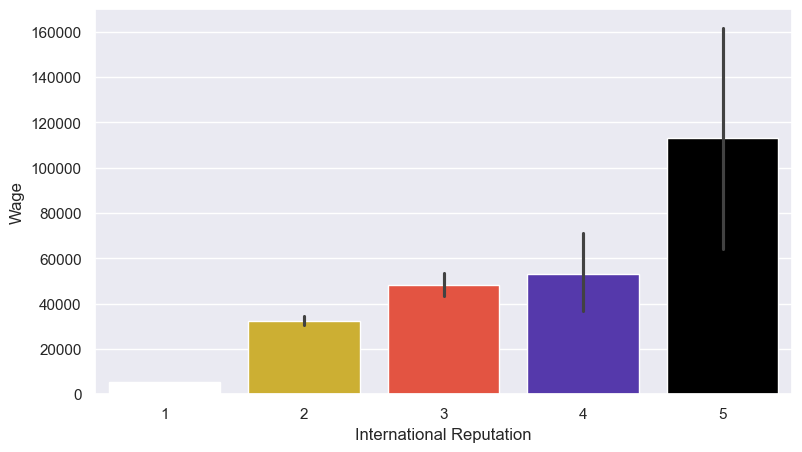

In [230]:
plt.figure(figsize=(9,5))
sns.barplot(x = 'International Reputation', y ='Wage',
            palette='CMRmap_r' ,data = wage_df, hue='International Reputation', legend=False)

### 2.5. Question 5:
- What is the age distribution in different clubs?
- Which club has most young players?

In [231]:
data = {'Age': df['age'], 'Club' : df['club_name']}
age_club_df = pd.DataFrame(data)

datas = age_club_df.groupby(by='Club', as_index=False).mean()
datas = datas.sort_values(by = 'Age', ascending = True)

datas.head(10)

Club        Age
666                   UCD  20.428571
696         Villarreal II  20.800000
108            Bordeaux W  21.100000
110  Borussia Dortmund II  21.185185
245           FC Volendam  21.300000
630      Stade de Reims W  21.400000
573              Salzburg  21.464286
264           Freiburg II  21.500000
461            Nürnberg W  21.600000
496   Peterborough United  21.720000

In [232]:
ex.bar(x = 'Club', y = 'Age', data_frame= datas.head(10),
      color='Club')

This graph provides several reserve teams. The teams with the youngest players are UCD (Ireland), Volendam (Netherlands) and Salzburg (Austria).

## 3. Lineup Visualizations

In [233]:
# adding the 'best_position' and 'value_million_eur' fields to each df
def add_position_and_value_fields(input_df):
    input_df['best_position'] = input_df['player_positions'].str.split(',').str[0]
    # about 1k players through FIFA version have no values associated - the NaN 'value_eur' values are replaced with 0
    input_df['value_eur'] = input_df['value_eur'].fillna(0)
    input_df['value_million_eur'] = pd.to_numeric(input_df['value_eur'], errors='coerce') / 1000000
    return input_df

df = add_position_and_value_fields(df)

In [234]:
from mplsoccer import VerticalPitch
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, ConnectionPatch, Arc
from matplotlib.font_manager import FontProperties
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

formations_dict = {'4-3-1-2': ['GK', 'RB|RWB', 'LCB|CB', 'RCB|CB', 'LB|LWB', 'CDM|CM', 'CDM|CM', 'CDM|CM', 'CAM|CF', 'CF|ST', 'CF|ST'],
                   '4-3-2-1': ['GK', 'RB|RWB', 'LCB|CB', 'RCB|CB', 'LB|LWB', 'CDM|CM', 'CDM|CM', 'CDM|CM', 'CAM|CF', 'CAM|CF', 'CF|ST'],
                   '4-3-3': ['GK', 'RB|RWB', 'LCB|CB', 'RCB|CB', 'LB|LWB', 'CDM|CM', 'CDM|CM', 'CDM|CM', 'RW|RF|ST', 'CF|ST', 'LW|LF|ST'],
                   '4-4-2': ['GK', 'RB|RWB', 'RCB|CB', 'LCB|CB', 'LB|LWB', 'RM|RW', 'CDM|CM', 'CDM|CM', 'LM|LW', 'CF|ST', 'CF|ST'],
                   '4-5-1': ['GK', 'RB|RWB', 'RCB|CB', 'LCB|CB', 'LB|LWB', 'RM|RW', 'CDM|CM', 'CDM|CM', 'LM|LW', 'CF|ST', 'CF|ST'],
                   '3-4-1-2': ['GK', 'RCB|CB', 'CB', 'LCB|CB', 'RM|RW', 'CDM|CM', 'CDM|CM', 'LM|LW', 'CAM|CF', 'CF|ST', 'CF|ST'],
                   '3-4-3': ['GK', 'RCB|CB', 'CB', 'LCB|CB', 'RWB|RM', 'CDM|CM', 'CDM|CM', 'LWB|LM', 'RW|RF|ST', 'CF|ST', 'LW|LF|ST'],
                   '3-5-2': ['GK', 'RCB|CB', 'CB', 'LCB|CB', 'RM|RWB|RB', 'CDM|CM', 'CDM|CM', 'CDM|CM', 'LM|LWB|LB', 'CF|ST', 'CF|ST']}
#This dict contains the most popular formations in Football with their positions.

# dictionary used to calculate the player coordinates on the pitch, based on the number of players per team section such as defence, etc.
xaxis_locations = {1: [40], 2: [30, 50], 3: [25, 40, 55], 4: [10, 30, 50, 70], 5: [10, 25, 40, 55, 70]}

def get_players_section_coord_col(players_coord_dict, players_col_dict, color_val, players_in_section, yaxis_val, team_order):
    if team_order == 'home':
        xaxis_val = xaxis_locations
    elif team_order == 'away':
        xaxis_val = {k: v[::-1] for k, v in xaxis_locations.items()} # reversing the X-axis for the opponent lineup
        yaxis_val = 120 - yaxis_val # total pitch length is 120, so positions have the same distance from the own team's goal
    else:
        raise ValueError('Invalid team_order value provided - Can be only "home" or "away"')
    for idx, val in enumerate(range(players_in_section)):
        players_coord_dict[len(players_coord_dict)] = [xaxis_val[players_in_section][idx], yaxis_val]
        players_col_dict[len(players_col_dict)] = color_val
    return players_coord_dict, players_col_dict

def get_player_locations_colors(formation, team_type='home'):
    lineup_sections = formation.split('-')
    defenders = int(lineup_sections[0])
    midfielders = int(lineup_sections[1])
    if len(lineup_sections) == 4:
        trequartistas = int(lineup_sections[2])
        strikers = int(lineup_sections[3])
    elif len(lineup_sections) == 3:
        trequartistas = 0
        strikers = int(lineup_sections[2])
    if len(lineup_sections) not in [3, 4] or (defenders + midfielders + trequartistas + strikers) != 10:
        raise ValueError('Formation invalid - Missing or extra player sections other than defence, midfield, and offence')
    # getting the player locations and colors in two dictionaries that are gradually populated
    locations_dict = {}
    colors_dict = {}
    locations_dict, colors_dict = get_players_section_coord_col(locations_dict, colors_dict, 'darkslategrey', 1, 112, team_type) # Goalkeeper
    locations_dict, colors_dict = get_players_section_coord_col(locations_dict, colors_dict, 'blue', defenders, 98, team_type) # Defenders
    locations_dict, colors_dict = get_players_section_coord_col(locations_dict, colors_dict, 'gold', midfielders, 84, team_type) # Midfielders
    if trequartistas > 0:
        locations_dict, colors_dict = get_players_section_coord_col(locations_dict, colors_dict, 'red', trequartistas, 77, team_type) # Central attacking midfielders
    locations_dict, colors_dict = get_players_section_coord_col(locations_dict, colors_dict, 'red', strikers, 70, team_type) # Strikers
    return locations_dict, colors_dict

def get_best_formation(formation_df, club_name='', measurement='overall'):
    if club_name != '':
        formation_df = formation_df[formation_df['club_name'] == club_name]
    formations_total_vals = {}
    for formation in formations_dict:
        copied_df = formation_df.copy()
        pos_list = formations_dict[formation]
        total_vals = []
        for pos in pos_list:
            # get best record based on 'overall' or 'potential', then drop that record from copied df, so that it cannot be selected again
            if not np.isnan(copied_df[copied_df['best_position'].str.contains(pos)][measurement].max()):
                total_vals.append(copied_df[copied_df['best_position'].str.contains(pos)][measurement].max())
                copied_df.drop(copied_df[copied_df['best_position'].str.contains(pos)][measurement].idxmax(), inplace=True)
        if len(total_vals) == 11:
            formations_total_vals[formation] = sum(total_vals)
        else: # some formations might not find 11 available players - these ones need to be excluded from any possible calcuation
            formations_total_vals[formation] = 0
    best_formation = max(formations_total_vals, key=formations_total_vals.get)
    return best_formation

def get_best_lineup(lineup_df, club_name='', formation='', measurement=''):
    if club_name != '':
        df_copy = lineup_df[lineup_df['club_name'] == club_name]
    else:
        df_copy = lineup_df.copy()
    # if formation is not chosen, then the best one is calculated with a formula
    if formation == '':
        formation = get_best_formation(lineup_df, club_name, measurement)
    squad_lineup = formations_dict[formation]
    squad_default_dict = dict()
    for pos in squad_lineup:
        best_player_record = df_copy.loc[[df_copy[df_copy['best_position'].str.contains(pos)][measurement].idxmax()]]
        squad_default_dict[best_player_record['short_name'].to_string(index=False).strip(' \t')] = [
            best_player_record['best_position'].to_string(index=False).strip(' \t'),
            int(best_player_record[measurement].to_string(index=False)),
            int(best_player_record['age'].to_string(index=False)),
            float(best_player_record['value_million_eur'].to_string(index=False)),
            best_player_record['club_name'].to_string(index=False).strip(' \t')]
        df_copy.drop(df_copy[df_copy['best_position'].str.contains(pos)][measurement].idxmax(), inplace=True)
    return formation, squad_default_dict

def draw_pitch(axis):
    # pitch outline and centre line
    pitch = Rectangle([0, 0], width=80, height=120, edgecolor='black', fill=False) # facecolor='#23E04F'
    # left and right penalty area and midline
    left_penalty = Rectangle([22.3, 0], width=35.3, height=14.6, fill=False)
    right_penalty = Rectangle([22.3, 105.4], width=35.3, height=14.6, fill=False)
    midline = ConnectionPatch([0, 60], [80, 60], 'data', 'data')
    # left and right six-yard box
    left_six_yard = Rectangle([32, 0], width=16, height=4.9, fill=False)
    right_six_yard = Rectangle([32, 115.1], width=16, height=4.9, fill=False)
    # prepare circles
    centre_circle = plt.Circle((40, 60), 8.1, color='black', fill=False)
    centre_spot = plt.Circle((40, 60), 0.4, color='black')
    # penalty spots and arcs around penalty boxes
    # left_pen_spot = plt.Circle((40, 9.7), 0.4, color='black')
    # right_pen_spot = plt.Circle((40, 110.3), 0.4, color='black')
    left_arch = Arc((40, 9.5), width=16.2, height=16.2, angle=90, theta1=310, theta2=50, color='black')
    right_arch = Arc((40, 110.4), width=16.2, height=16.2, angle=90, theta1=130, theta2=230, color='black')
    elements_list = [pitch, left_penalty, right_penalty, midline, left_six_yard, right_six_yard, centre_circle, centre_spot, left_arch, right_arch]
    for element in elements_list:
        axis.add_patch(element)

def draw_teams_matchup(home_df, away_df, home_title, away_title, home_team_name='', away_team_name='',
                       home_team_formation='', away_team_formation='', measurement='overall', drawn_pitch='manual'):
    # setting the figure where the matchup will be plotted
    fig = plt.figure()
    fig.set_size_inches(10, 14)
    ax = fig.add_subplot(1, 1, 1)
    if drawn_pitch == 'mplsoccer': # plotting the fancy pitch from 'mplsoccer'
        pitch = VerticalPitch(pitch_color='grass', line_color='white', stripe=True)
        pitch.draw(ax=ax)
    else: # calling the function that draws the pitch
        draw_pitch(ax)
    # setting the field columns shown on the right-hand side of the figure
    if measurement == 'overall':
        note_columns = ('Position', 'Player Name', 'Overall Attribute', 'Age', 'Player Value (in €M)', 'Club Name')
    elif measurement == 'potential':
        note_columns = ('Position', 'Player Name', 'Potential Attribute', 'Age', 'Player Value (in €M)', 'Club Name')
    else:
        raise ValueError('Measurement value provided is not valid (nor "overall" neither "potential")')
    # drawing home team lineup
    home_formation, home_players = get_best_lineup(home_df, home_team_name, home_team_formation, measurement)
    home_players_list = list(home_players)
    home_locations_dict, home_colors_dict = get_player_locations_colors(home_formation, team_type='home')
    for i in range(len(home_players_list)):
        player_x, player_y = home_locations_dict[i][0], home_locations_dict[i][1]
        player_color = home_colors_dict[i]
        if '. ' in home_players_list[i]:
            player_name = home_players_list[i].split('. ', 1)[1]
        else:
            player_name = home_players_list[i]
        plt.annotate(player_name,
                     xy = (player_x, player_y), xytext = (0, 18),
                     bbox=dict(boxstyle='round', fc='w'), va='center', ha='center', textcoords='offset points')
        plt.scatter(player_x, player_y, s=250, c=player_color)
    # adding notes on the right-hand side of the home team
    home_team_list = []
    for k, v in home_players.items():
        home_team_list.append([v[0], k, v[1], v[2], v[3], v[4]])
    home_sum_rating = home_sum_age = home_sum_value = 0
    for k, v in home_players.items():
        home_sum_rating = home_sum_rating + v[1]
        home_sum_age = home_sum_age + v[2]
        home_sum_value = home_sum_value + v[3]
    home_notes = [[home_title],
                  ['Average rating: {avg_rating}'.format(avg_rating=round((home_sum_rating/11), 1))],
                  ['Average age: {avg_age}'.format(avg_age=round((home_sum_age/11), 1))],
                  ['Total Value (in €M): {total_value:,}'.format(total_value=round(home_sum_value, 1))]]
    plt_table = plt.table(cellText=home_team_list, colLabels=note_columns,
                          colWidths=[0.3, 0.5, 0.35, 0.2, 0.4, 0.5], cellLoc='right', loc='right', bbox=[1, 0.505, 1.7, 0.36])
    plt_table.scale(1.5, 2)
    for (row, col), cell in plt_table.get_celld().items():
        if (row == 0):
            cell.set_text_props(fontproperties=FontProperties(weight='bold'))
    plt_home_notes = plt.table(cellText=home_notes, cellLoc='left', loc='left', bbox=[0.9, 0.87, 1.1, 0.12])
    for key, cell in plt_home_notes.get_celld().items():
        cell.set_linewidth(0)
        cell.set_text_props(fontproperties=FontProperties(weight='bold'))
    # drawing away team lineup
    away_formation, away_players = get_best_lineup(away_df, away_team_name, away_team_formation, measurement)
    away_players_list = list(away_players)
    away_locations_dict, away_colors_dict = get_player_locations_colors(away_formation, team_type='away')
    for i in range(len(away_players_list)):
        player_x, player_y = away_locations_dict[i][0], away_locations_dict[i][1]
        player_color = away_colors_dict[i]
        if '. ' in away_players_list[i]:
            player_name = away_players_list[i].split('. ', 1)[1]
        else:
            player_name = away_players_list[i]
        plt.annotate(player_name,
                     xy = (player_x, player_y), xytext = (0, 18),
                     bbox=dict(boxstyle='round', fc='w'), va='center', ha='center', textcoords='offset points')
        plt.scatter(player_x, player_y, s=250, c=player_color)
    # adding notes on the right-hand side of the away team
    away_team_list = []
    for k, v in away_players.items():
        away_team_list.append([v[0], k, v[1], v[2], v[3], v[4]])
    away_sum_rating = away_sum_age = away_sum_value = 0
    for k, v in away_players.items():
        away_sum_rating = away_sum_rating + v[1]
        away_sum_age = away_sum_age + v[2]
        away_sum_value = away_sum_value + v[3]
    away_notes = [[away_title],
                  ['Average rating: {avg_rating}'.format(avg_rating=round((away_sum_rating/11), 1))],
                  ['Average age: {avg_age}'.format(avg_age=round((away_sum_age/11), 1))],
                  ['Total Value (in €M): {total_value:,}'.format(total_value=round(away_sum_value, 1))]]
    plt_table = plt.table(cellText=away_team_list, colLabels=note_columns,
                          colWidths=[0.3, 0.5, 0.35, 0.2, 0.4, 0.5], cellLoc='right', loc='right', bbox=[1, 0.015, 1.7, 0.36])
    plt_table.scale(1.5, 2)
    for (row, col), cell in plt_table.get_celld().items():
        if (row == 0):
            cell.set_text_props(fontproperties=FontProperties(weight='bold'))
    plt_away_notes = plt.table(cellText=away_notes, cellLoc='left', loc='left', bbox=[0.9, 0.38, 1.1, 0.12])
    for key, cell in plt_away_notes.get_celld().items():
        cell.set_linewidth(0)
        cell.set_text_props(fontproperties=FontProperties(weight='bold'))
    # adding the final settings to the plot
    plt.xlim(-2, 82)
    plt.ylim(-2, 122)
    plt.axis('off')
    plt.show()


### 3.1. Exemple 1

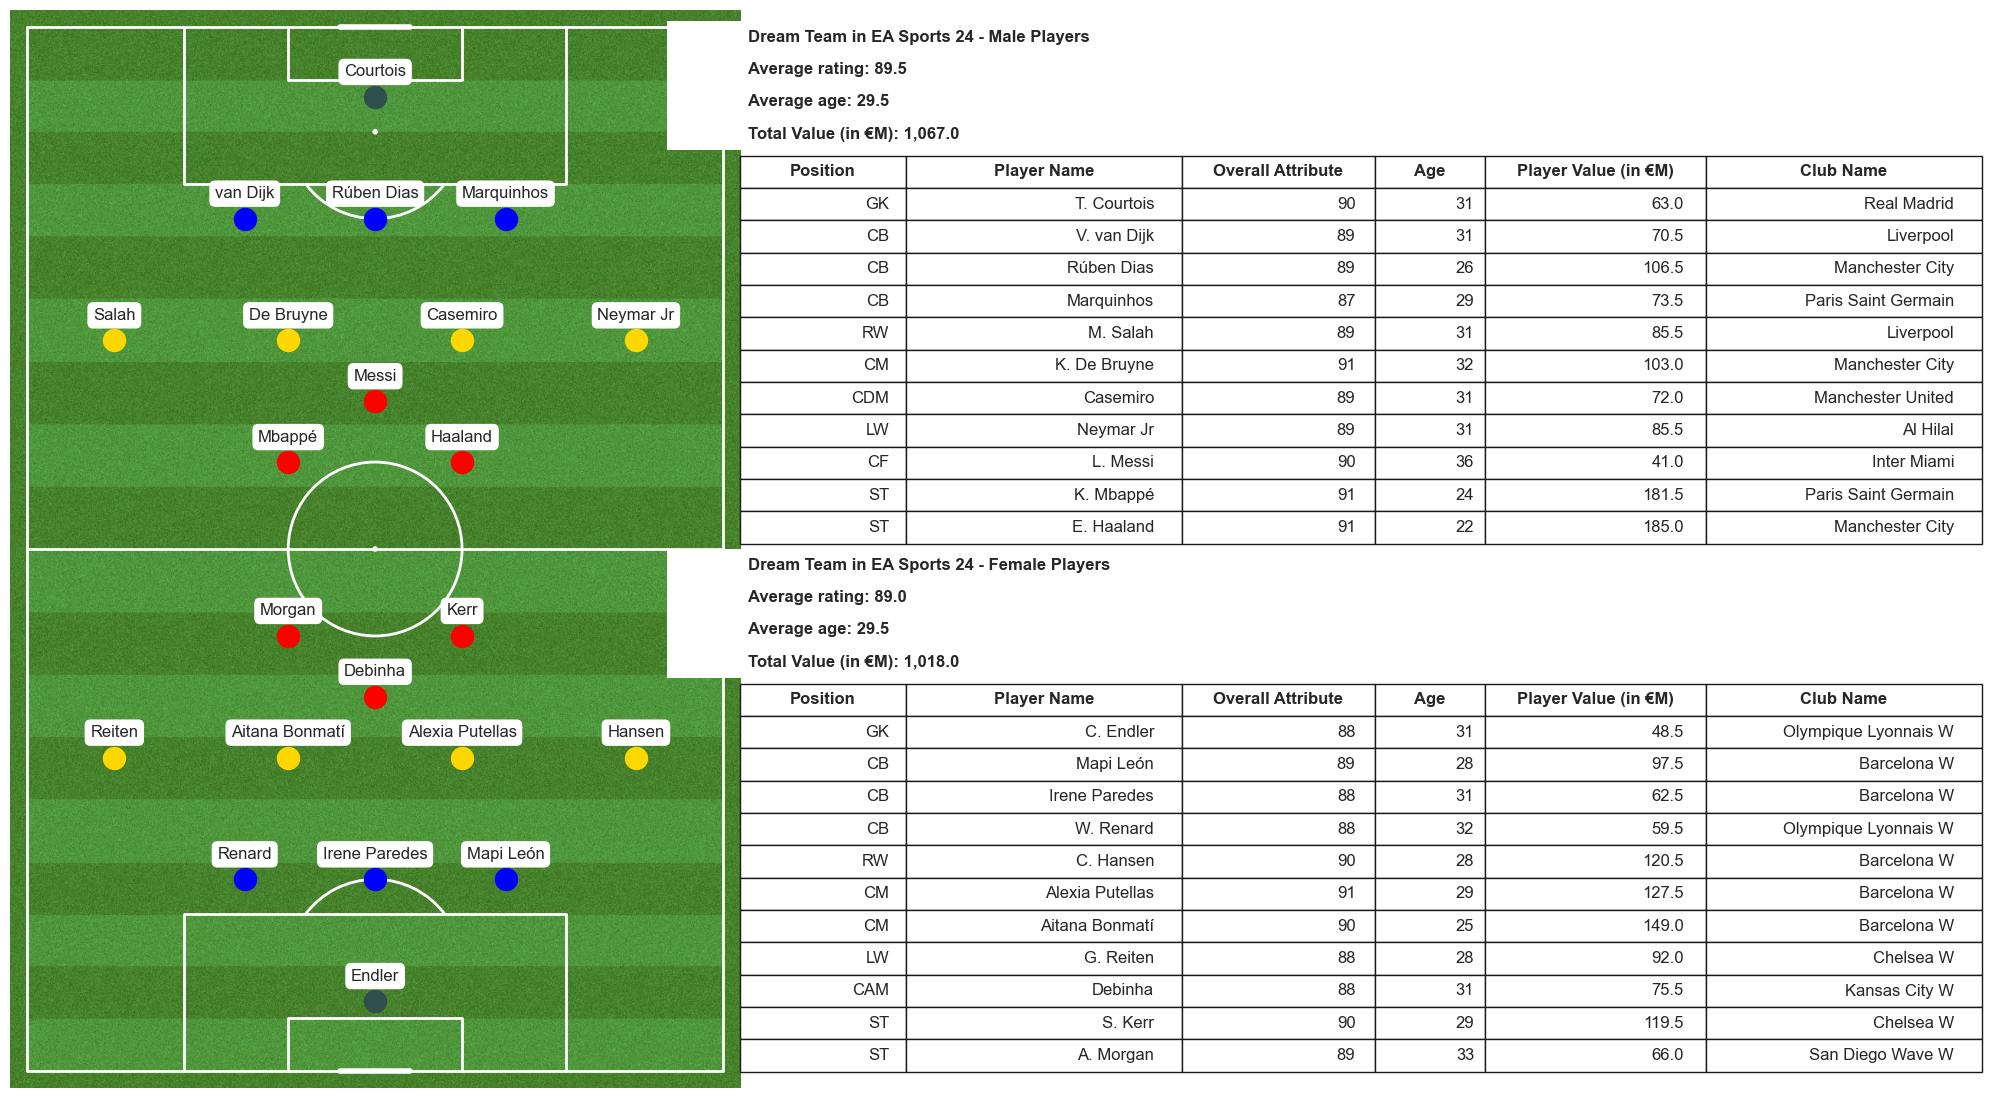

In [235]:
df["Potential difference"] = df["potential"] - df["overall"]

df_male = df[df['gender'] == 'M']
df_female = df[df['gender'] == 'F']

draw_teams_matchup(df_male, df_female, 'Dream Team in EA Sports 24 - Male Players', 'Dream Team in EA Sports 24 - Female Players', drawn_pitch='mplsoccer')

### 3.2. Exemple 2

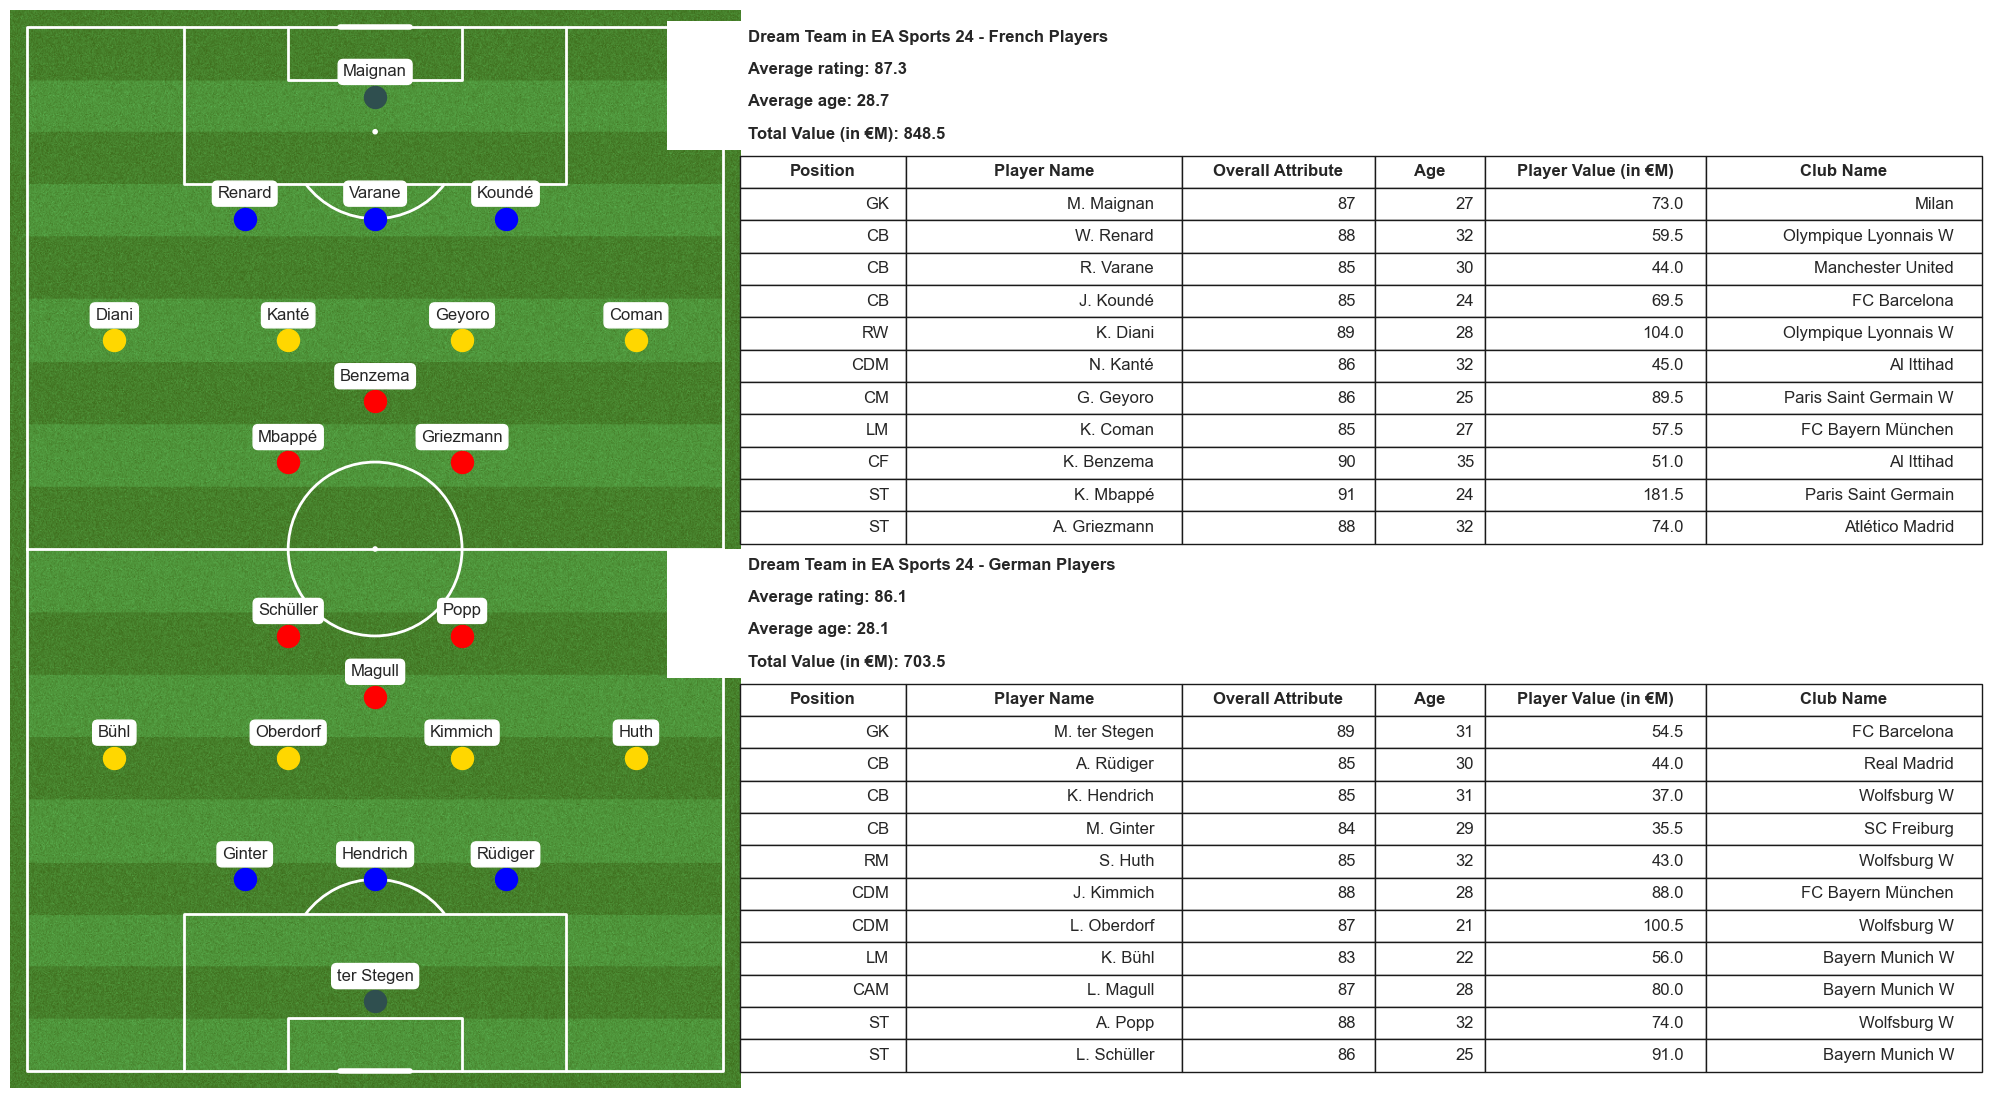

In [236]:
df_france = df[df['nationality_name'] == 'France']
df_germany = df[df['nationality_name'] == 'Germany']

draw_teams_matchup(df_france, df_germany, 'Dream Team in EA Sports 24 - French Players', 'Dream Team in EA Sports 24 - German Players', drawn_pitch='mplsoccer')

### 3.3. Exemple 3

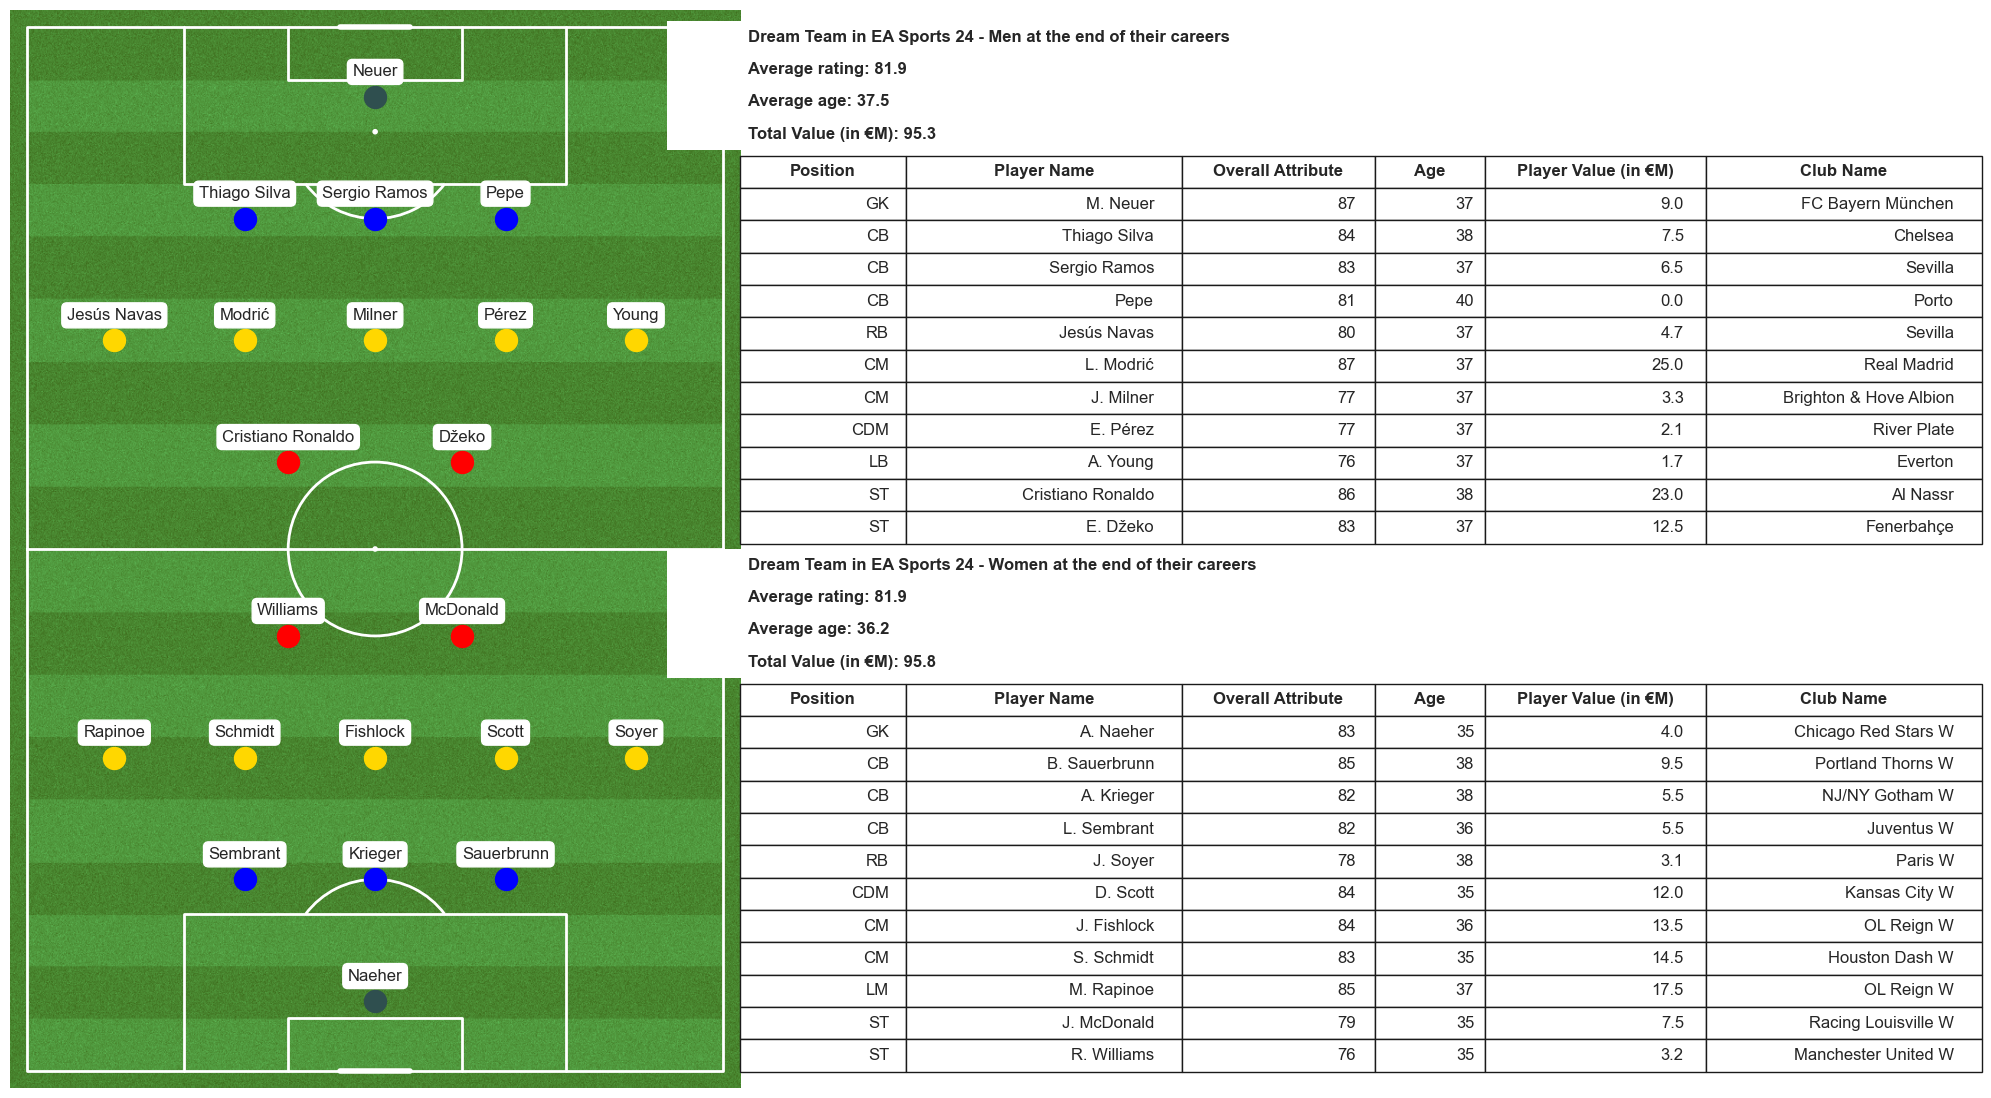

In [237]:
df_male_wonderkids = df_male[df_male["age"] > 36]
df_female_wonderkids = df_female[df_female["age"] > 34]

draw_teams_matchup(df_male_wonderkids, df_female_wonderkids, 'Dream Team in EA Sports 24 - Men at the end of their careers', 'Dream Team in EA Sports 24 - Women at the end of their careers', drawn_pitch='mplsoccer')

## 4. Gaps

We can identify several gaps that remain to be explored for the future:

- It would be interesting to create a man-machine interface to choose its criteria and obtain our visualisations.
- It might be interesting to look more deeply for example, to get the best team possible, with a team quality/value ratio.
- Ability to create a dataset, with information drawn from the real world and no longer from FIFA, via webscraping, to apply these visualizations to real player performance.